# Setup

WARNING: this notebook requires files created by the _preproces_regulations_ notebook

## Load libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re
from os import listdir, mkdir, getcwd, chdir
from os.path import join
import nltk
nltk.download('averaged_perceptron_tagger')
import requests
import zipfile
from scipy.linalg import norm
from scipy.spatial.distance import cosine
import sys
import time
import pickle

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
HOME = getcwd()
timestamp = time.strftime('%Y-%m-%d_%H-%M-%S')

## Load Part 121

In [3]:
filepath = join(HOME, 'Regulations', 'FAR_Part121_sections.xlsx')
df_part121_sections = pd.read_excel(filepath)[['title', 'requirement']]
filepath = join(HOME, 'Regulations', 'FAR_Part121_nodes.xlsx')
df_part121_nodes = pd.read_excel(filepath)[['title', 'requirement']]

## Load RBAC 121

In [4]:
## IMPLEMENT WITH TRANSLATED REGULATION

# Pre-processing:

## Tokenizer

In [5]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = '<OOV>')

In [6]:
tokenizer.fit_on_texts(df_part121_sections.requirement.tolist())
#tokenizer.fit_on_texts(df_RBAC121_sections.translation.tolist())

In [7]:
tokenizer.word_index

{'<OOV>': 1,
 'the': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'in': 6,
 'to': 7,
 'or': 8,
 'for': 9,
 'this': 10,
 '121': 11,
 'that': 12,
 'flight': 13,
 'an': 14,
 'is': 15,
 'by': 16,
 'certificate': 17,
 'be': 18,
 'airplane': 19,
 'must': 20,
 'as': 21,
 'may': 22,
 '§': 23,
 'each': 24,
 'with': 25,
 'fr': 26,
 'section': 27,
 '1': 28,
 'at': 29,
 'holder': 30,
 'no': 31,
 'training': 32,
 '2': 33,
 'b': 34,
 'required': 35,
 'operations': 36,
 'any': 37,
 'on': 38,
 'paragraph': 39,
 'under': 40,
 'part': 41,
 'person': 42,
 'amdt': 43,
 'c': 44,
 'pilot': 45,
 'not': 46,
 'requirements': 47,
 'aircraft': 48,
 'are': 49,
 'approved': 50,
 'if': 51,
 '3': 52,
 'type': 53,
 'than': 54,
 'after': 55,
 'it': 56,
 'from': 57,
 'passenger': 58,
 'airport': 59,
 'all': 60,
 'airplanes': 61,
 'unless': 62,
 'd': 63,
 'other': 64,
 'i': 65,
 'hours': 66,
 'emergency': 67,
 'doc': 68,
 'which': 69,
 'system': 70,
 'has': 71,
 'time': 72,
 'following': 73,
 'except': 74,
 'more': 75,
 'procedure

In [8]:
chdir(HOME)
if 'models' not in listdir():
    mkdir('models')

tokenizer_filename = 'tokenizer___' + timestamp + '.h5'
with open(join(HOME, 'models', tokenizer_filename), 'wb') as file:
    pickle.dump(tokenizer, file, protocol=pickle.HIGHEST_PROTOCOL)

## Part-of-speech (POS) filter

In [9]:
def relevant_words(excerpt):
    tokens = re.findall('[a-zA-Z]{3,}', excerpt)
    words, allowed_pos = [], ['NN','NNS','NNP','NNPS','JJ','RB','VB','VBG','VBN','VBP','VBZ','VBD']
    for item in nltk.pos_tag(tokens):
        if item[0] not in words and item[1] in allowed_pos:
            words.append(item[0])
    return words

Print example:

In [11]:
EXAMPLE_NUMBER = 10
print(df_part121_nodes.requirement[EXAMPLE_NUMBER])
print(relevant_words(df_part121_nodes.requirement[EXAMPLE_NUMBER]))

§ 121.2   Compliance schedule for operators that transition to part 121; certain new entrant operators.
(b) Obtaining operations specifications. A certificate holder described in paragraph (a)(1) of this section may not, after March 20, 1997, operate an airplane described in paragraphs (a)(1)(i), (a)(1)(ii), or (a)(1)(iii) of this section in scheduled passenger-carrying operations, unless it obtains operations specifications to conduct its scheduled operations under this part on or before March 20, 1997. 

['Compliance', 'schedule', 'operators', 'transition', 'part', 'certain', 'new', 'entrant', 'Obtaining', 'operations', 'specifications', 'certificate', 'holder', 'described', 'section', 'not', 'March', 'operate', 'airplane', 'paragraphs', 'iii', 'scheduled', 'passenger', 'carrying', 'obtains', 'conduct']


## Sort words according to relative frequency

Define function that receives list of words and returns list sorted according to increasing frequency in the tokenizer

In [12]:
def sorted_keywords(words, tokenizer):
    w,f = [], []

    for word in words:
        if word in tokenizer.word_index.keys():
            w.append(word)
            f.append(tokenizer.word_counts[word])

    sorting_indices = np.array(f).argsort()
    return np.array(w)[sorting_indices]

Print example:

In [14]:
EXAMPLE_NUMBER = 100

excerpt = df_part121_sections.requirement[EXAMPLE_NUMBER]
print(excerpt)
print(sorted_keywords(relevant_words(excerpt), tokenizer))

§ 121.289   Landing gear: Aural warning device.(a) Except for airplanes that comply with the requirements of § 25.729 of this chapter on or after January 6, 1992, each airplane must have a landing gear aural warning device that functions continuously under the following conditions: 
(1) For airplanes with an established approach wing-flap position, whenever the wing flaps are extended beyond the maximum certificated approach climb configuration position in the Airplane Flight Manual and the landing gear is not fully extended and locked. 
(2) For airplanes without an established approach climb wing-flap position, whenever the wing flaps are extended beyond the position at which landing gear extension is normally performed and the landing gear is not fully extended and locked. 
(b) The warning system required by paragraph (a) of this section - 
(1) May not have a manual shutoff; 
(2) Must be in addition to the throttle-actuated device installed under the type certification airworthiness 

## Pre-trained word embeddings

Download and unzip pre-trained embeddings

In [15]:
URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
chdir(HOME)

if 'GloVe' not in listdir():
    mkdir('GloVe')

chdir(join(HOME, 'GloVe'))

if 'glove.6B.300d.txt' not in listdir():
    r = requests.get(URL)
    with open('glove.6B.zip', 'wb') as file:
        file.write(r.content)
    zip = zipfile.ZipFile('glove.6B.zip')
    zip.extractall()
    
chdir(HOME)

Prepare embedding dictionary

In [16]:
embedding_dict = {}

with open(join(getcwd(), 'GloVe', 'glove.6B.300d.txt'), encoding='UTF-8') as file:
    for line in file:
        token, vector = line.split(maxsplit=1)
        embedding_dict[token] = np.array(vector.replace('\n','').split(' ')).astype('float')

Prepare embedding matrix

In [17]:
dict_size = len(tokenizer.word_index)
embedding_dim = 300
embedding_vectors = [np.zeros(embedding_dim)]

for word, index in tokenizer.word_index.items():
    embedding = embedding_dict.get(word)
    if embedding is None:
        embedding_vectors.append(np.zeros(embedding_dim))
    else:
        embedding_vectors.append(embedding)

embedding_matrix = np.array(embedding_vectors)

Create keras embedding_layer:

In [18]:
embedding_layer = tf.keras.layers.Embedding(input_dim = dict_size + 1, 
                                            output_dim = embedding_dim, 
                                            embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                                            trainable=False)

In [19]:
chdir(HOME)
if 'models' not in listdir():
    mkdir('models')

embedding_layer_filename = 'embedding_layer___' + timestamp + '.h5'
with open(join(HOME, 'models', embedding_layer_filename), 'wb') as file:
    pickle.dump(embedding_layer, file, protocol=pickle.HIGHEST_PROTOCOL)

Run tests on embedding:

In [20]:
e = embedding_dict
vec = e['paris'] - e['france'] + e['germany']

distances = np.array([cosine(vec, e[word]) for word in e.keys()])
index = np.array(distances).argmin()
list(e.keys())[index]

'berlin'

## Modified Jaccard similarity index

In [21]:
def jaccard_mod(string1, string2, max_words = None):
    # with max_words != None, repetitions are ignored, only the frequency in the original dictionary is used
    # with max_words == None, repetitions are somewhat accounted for (not very thoughtfully..)
    
    cutoff = .5
    
    if max_words == None:
        tokens1 = tokenizer.texts_to_sequences(relevant_words(string1))
        tokens2 = tokenizer.texts_to_sequences(relevant_words(string2))
    else:
        tokens1 = sorted_keywords(relevant_words(string1), tokenizer)
        tokens1 = tokenizer.texts_to_sequences(tokens1[:max_words])
        tokens2 = sorted_keywords(relevant_words(string2), tokenizer)
        tokens2 = tokenizer.texts_to_sequences(tokens2[:max_words])
        
    if len(tokens1) < 2 or len(tokens2) < 2:
        return 0
    else:
        embedding1 = embedding_layer(np.array(tokens1)).numpy().squeeze()
        norms1 = norm(embedding1, axis=1)
        embedding1 = embedding1[norms1 != 0]
        norms1 = norms1[norms1 != 0].reshape([-1,1])

        embedding2 = embedding_layer(np.array(tokens2)).numpy().squeeze()
        norms2 = norm(embedding2, axis=1)
        embedding2 = embedding2[norms2 != 0]
        norms2 = norms2[norms2 != 0].reshape([-1,1])

        cosine_similarity = np.matmul(embedding1, embedding2.T) / norms1 / norms2.T
        tril = np.ones_like(cosine_similarity) * (np.tril(cosine_similarity) != 0).astype(int)

        intersection = np.sum((cosine_similarity * cosine_similarity) > cutoff)
        union = cosine_similarity.shape[0] + cosine_similarity.shape[1] - intersection

        return intersection/union

Example using individual requirements:

Similarity: 0.37037037037037035

Relevant words from excerpt 1:
['entrant' 'details' 'moving' 'commuter' 'schedules' 'complying'
 'operators' 'contained' 'events' 'certain' 'plan' 'containing' 'new'
 'contain' 'submit' 'schedule' 'transition' 'described' 'date' 'calendar'
 'scheduled' 'domestic' 'paragraphs' 'compliance' 'flag' 'conducting'
 'chapter' 'following' 'requirements' 'part' 'paragraph' 'operations'
 'holder' 'section' 'certificate']

Relevant words from excerpt 2:
['credited' 'annotated' 'entrant' 'entitled' 'reflect' 'obtained' 'dates'
 'operators' 'kept' 'credit' 'certain' 'meeting' 'new' 'schedule'
 'purpose' 'specific' 'determined' 'transition' 'described'
 'qualification' 'meets' 'approval' 'comply' 'paragraphs' 'compliance'
 'applicable' 'crewmember' 'chapter' 'operating' 'equipment' 'airplanes'
 'requirements' 'part' 'paragraph' 'training' 'holder' 'section'
 'airplane' 'certificate']



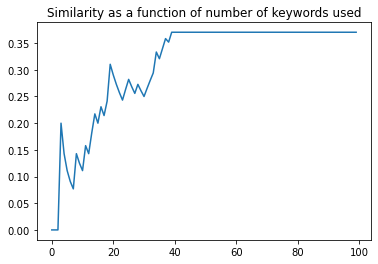

In [23]:
excerpt1 = df_part121_nodes.requirement[19]
excerpt2 = df_part121_nodes.requirement[20]

print('Similarity: {}\n'.format(jaccard_mod(excerpt1, excerpt2, 50)))
print('Relevant words from excerpt 1:\n{}\n'.format(sorted_keywords(relevant_words(excerpt1), tokenizer)))
print('Relevant words from excerpt 2:\n{}\n'.format(sorted_keywords(relevant_words(excerpt2), tokenizer)))

sim = []
for n in range(100):
    sim.append(jaccard_mod(excerpt1, excerpt2, n))
plt.plot(sim)
plt.title('Similarity as a function of number of keywords used')
plt.show()

Example using full sections

Similarity: 0.13076923076923078

Relevant words from excerpt 1:
['widths' 'density' 'advisory' 'airways' 'considers' 'width' 'segments'
 'foreign' 'determine' 'airborne' 'clearance' 'equal' 'traffic' 'aids'
 'routes' 'finds' 'determined' 'designated' 'altitudes' 'navigation'
 'specifications' 'necessary' 'route' 'have' 'specified' 'amended'
 'procedures' 'following' 'other' 'are' 'operations' 'holder'
 'certificate']

Relevant words from excerpt 2:
['usage' 'dissemination' 'clearways' 'stopways' 'thresholds' 'measurement'
 'distributing' 'computations' 'stay' 'winds' 'collection' 'maintaining'
 'gradient' 'granted' 'charged' 'filing' 'pending' 'file' 'stays'
 'obstacles' 'overall' 'size' 'obtaining' 'aeronautical' 'receives'
 'navigational' 'interest' 'reconsider' 'uses' 'range' 'affecting'
 'reasons' 'petition' 'continued' 'notification' 'obstructions' 'public'
 'revisions' 'proposed' 'lighting' 'decision' 'low' 'change' 'statement'
 'notice' 'requires' 'items' 'considering' 'properly

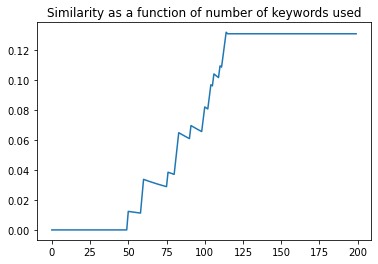

In [24]:
excerpt1 = df_part121_sections.requirement[19]
excerpt2 = df_part121_sections.requirement[20]

print('Similarity: {}\n'.format(jaccard_mod(excerpt1, excerpt2, 200)))
print('Relevant words from excerpt 1:\n{}\n'.format(sorted_keywords(relevant_words(excerpt1), tokenizer)))
print('Relevant words from excerpt 2:\n{}\n'.format(sorted_keywords(relevant_words(excerpt2), tokenizer)))

sim = []
for n in range(200):
    sim.append(jaccard_mod(excerpt1, excerpt2, n))
plt.plot(sim)
plt.title('Similarity as a function of number of keywords used')
plt.show()